code from: https://github.com/yangjenny/adversarial_learning_bias_mitigation

##Helper function from FAIM framework for getting AUC confidence interval

In [ ]:
def get_ci_auc(y_true, y_pred, alpha=0.05, type="auc"):
    """Calculate the confidence interval for the AUC (Area Under the Curve) score
    or PR (Precision-Recall) score using bootstrapping.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted scores or probabilities.
        alpha (float, optional): Significance level for the confidence interval. Default is 0.05.
        type (str, optional): Type of score to calculate: 'auc' (default) or 'pr' (precision-recall).

    Returns:
        tuple: Tuple containing the lower and upper bounds of the confidence interval.
    """

    n_bootstraps = 1000
    bootstrapped_scores = []
    seed = 1234
    np.random.seed(seed)
    rng = np.random.RandomState(seed)

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))

        if len(np.unique(y_true[indices])) < 2:
            continue

        if type == "pr":
            precision, recall, thresholds = precision_recall_curve(
                y_true[indices], y_pred[indices]
            )
            score = auc(recall, precision)
        else:
            score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # 95% c.i.
    confidence_lower = sorted_scores[int(alpha / 2 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(1 - alpha / 2 * len(sorted_scores))]

    return confidence_lower, np.median(sorted_scores), confidence_upper


###adversarial_training_framework.py

In [ ]:
import pandas as pd
import numpy as np
import sympy
if not hasattr(sympy.core.numbers, 'equal_valued'):
    sympy.core.numbers.equal_valued = lambda x, y: x == y
import torch
from torch.autograd import Variable
import itertools
import os
import random
import pickle
import math
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve

# chosen hyperparameters
hyperparameter_list = ['learning_rate', 'num_iters', 'num_nodes', 'num_nodes_adv', 'dropout_rate', 'alpha']

# get_new_control_indices is used when you want to get a specific controls:cases ratio
# Set true when running basic model for the first time
# set false once indices already generated for the first time
get_new_control_indices = False
#Set true if we want to just use data as is (i.e. don't bother with matching controls)
use_data_as_is = True

# metrics used in evaluation
# number labels of the protected variable (k)
def get_metrics(ypred, y, z, hyperparameters, k=7, yselect=0, eval_file=None, zpred=None):
    metrics = dict()
    metrics['eval_file'] = eval_file

    # add hyperparameters for experiment
    for i in range(len(hyperparameters)):
        metrics[hyperparameter_list[i]] = hyperparameters[i]

    # performance metrics
    pred = (ypred >= 0.5).astype(int)

    # Base confusion matrix
    TN, FN, FP, TP = confusion_matrix(pred, y)
    print(f"TN: {TN}, FN: {FN}, FP: {FP}, TP: {TP}")

    # Standard metrics
    metrics['accuracy'] = accuracy_score(pred, y)
    metrics['recall'] = TP / (FN + TP + 1e-8)
    metrics['precision'] = TP / (FP + TP + 1e-8)
    metrics['specificity'] = TN / (TN + FP + 1e-8)
    metrics['f1score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'] + 1e-8)
    metrics['roc_auc'] = roc_auc_score(y, pred)

    # ========================
    # AUC with Confidence Intervals
    # ========================
    try:
        auc_low, auc_median, auc_high = get_ci_auc(y, ypred, alpha=0.05, type="auc")
        metrics['auc_low'] = auc_low
        metrics['auc'] = auc_median
        metrics['auc_high'] = auc_high
    except Exception as e:
        print(f"Warning: Could not calculate AUC confidence intervals: {e}")
        metrics['auc_low'] = np.nan
        metrics['auc'] = metrics['roc_auc']
        metrics['auc_high'] = np.nan

    # ========================
    #   GROUP FAIRNESS METRICS
    # ========================
    unique_groups = np.unique(z)

    # Store per-group stats for comparisons
    tpr_dict = {}
    fpr_dict = {}
    ber_dict = {}
    acc_dict = {}
    sr_dict = {}  # selection rate dictionary

    for g in unique_groups:
        idx = (z == g)
        y_g = y[idx]
        pred_g = pred[idx]

        # Confusion components per group
        TN_g, FN_g, FP_g, TP_g = confusion_matrix(pred_g, y_g)

        # True Positive Rate (TPR)
        TPR = TP_g / (TP_g + FN_g + 1e-8)

        # False Positive Rate (FPR)
        FPR = FP_g / (FP_g + TN_g + 1e-8)

        # Balanced Error Rate
        BER = 1 - 0.5 * (TPR + (1 - FPR))

        # Accuracy per group
        ACC = (TP_g + TN_g) / (TP_g + TN_g + FP_g + FN_g + 1e-8)

        # Selection Rate (proportion of positive predictions)
        SR = np.mean(pred_g)

        tpr_dict[g] = TPR
        fpr_dict[g] = FPR
        ber_dict[g] = BER
        acc_dict[g] = ACC
        sr_dict[g] = SR

    # Equal Opportunity difference = max TPR difference between groups
    metrics["equal_opportunity_diff"] = max(tpr_dict.values()) - min(tpr_dict.values())

    # Equalized Odds difference = max(FPR_diff) + max(TPR_diff) across groups
    metrics["equalized_odds_diff"] = (max(fpr_dict.values()) - min(fpr_dict.values()) +
                                     max(tpr_dict.values()) - min(tpr_dict.values()))

    # BER equality difference
    metrics["ber_equality_diff"] = max(ber_dict.values()) - min(ber_dict.values())

    # Statistical Parity (difference in selection rates between groups)
    metrics["statistical_parity_diff"] = max(sr_dict.values()) - min(sr_dict.values())

    # Accuracy Equality (difference in accuracy between groups)
    metrics["accuracy_equality_diff"] = max(acc_dict.values()) - min(acc_dict.values())

    return metrics


def predictmulti(prob_list):
    ind_list = []
    for probs in prob_list:
        ind_list.append(np.where(probs==np.max(probs))[0][0])
    return ind_list

def confusion_matrix(ypred, y):
    true_pos = np.sum((ypred == 1) & (y == 1))
    true_neg = np.sum((ypred == 0) & (y == 0))
    false_pos = np.sum((ypred == 1) & (y == 0))
    false_neg = np.sum((ypred == 0) & (y == 1))
    return true_neg, false_neg, false_pos, true_pos

# Model class used
class Adv_Model(object):
    def __init__(self, params):
        self.params = params
        self.method = self.params['method']
        self.adversarial = self.method != 'basic'
        self.num_classes = self.params['num_classes']
        self.hyperparameters = self.params['hyperparameters']
        self.model = self.build_model()
        self.data = self.data_processing()

    def get_indexes(self):
        num_models = []
        for i in range(len(hyperparameter_list)):
            if self.adversarial:
                # All hyperparameters are relevant for adversarial models
                num_models.append(range(len(self.hyperparameters[hyperparameter_list[i]])))
            else:
                # Basic model only uses learning_rate, num_iters, num_nodes, dropout_rate
                if hyperparameter_list[i] in ['learning_rate', 'num_iters', 'num_nodes', 'dropout_rate']:
                    num_models.append(range(len(self.hyperparameters[hyperparameter_list[i]])))
                else:
                    # Placeholder so indexing doesn't break
                    num_models.append([0])
        return itertools.product(*num_models)

    def get_hyperparameters(self, indexes):
        hyperparameters = []
        for i in range(len(indexes)):
            if (i < 3 or i == 4 or self.adversarial):
                hyperparameters.append(self.hyperparameters[hyperparameter_list[i]][indexes[i]])
                # Print chosen hyperparameters for this run
            else:
                hyperparameters.append(None)
        return hyperparameters

    def params_tostring(self, indexes):
        res = ''
        for i in range(len(hyperparameter_list)):
            if i > 0:
                res += '-'
            if (i < 3 or i == 4 or self.adversarial):
                res += hyperparameter_list[i] + '_' + str(self.hyperparameters[hyperparameter_list[i]][indexes[i]])
        return res

    def create_dir(self, dirname):
        if (not os.path.exists(dirname)):
            os.makedirs(dirname)

    def data_processing(self):
        data = dict()
        i, j = self.params['Xtrain'].shape
        i_valid, j_valid = self.params['Xvalid'].shape
        i_test, j_test = self.params['Xtest'].shape
        num_nodes = self.hyperparameters['num_nodes']

        data['Xtrain'] = Variable(torch.tensor(self.params['Xtrain'].values).float())
        data['ytrain'] = Variable(torch.tensor(self.params['ytrain'].values.reshape(i, 1)).float())
        data['Xvalid'] = Variable(torch.tensor(self.params['Xvalid'].values).float())
        data['yvalid'] = Variable(torch.tensor(self.params['yvalid'].values.reshape(i_valid, 1)).float())
        data['Xtest'] = Variable(torch.tensor(self.params['Xtest'].values).float())
        data['ytest'] = Variable(torch.tensor(self.params['ytest'].values.reshape(i_test, 1)).float())

        if self.num_classes > 2:
            data['ztrain'] = Variable(torch.tensor(self.params['ztrain'].values.reshape(self.params['ztrain'].shape[0],)).long())
            #data['zmatch'] = Variable(torch.tensor(self.params['zmatch'].values.reshape(self.params['zmatch'].shape[0],)).long())
            data['zvalid'] = Variable(torch.tensor(self.params['zvalid'].values.reshape(self.params['zvalid'].shape[0],)).long())
            data['ztest'] = Variable(torch.tensor(self.params['ztest'].values.reshape(self.params['ztest'].shape[0],)).long())
        else:
            data['ztrain'] = Variable(torch.tensor(self.params['ztrain'].values.reshape(self.params['ztrain'].shape[0],)).float())
            #data['zmatch'] = Variable(torch.tensor(self.params['zmatch'].values.reshape(self.params['zmatch'].shape[0],)).float())
            data['zvalid'] = Variable(torch.tensor(self.params['zvalid'].values.reshape(self.params['zvalid'].shape[0],)).float())
            data['ztest'] = Variable(torch.tensor(self.params['ztest'].values.reshape(self.params['ztest'].shape[0],)).float())

        data["z_group_map"] = self.params["z_group_map"]

        return data

    def build_model(self):
        models = {}
        for indexes in self.get_indexes():
                models[indexes] = self.build_single_model(indexes)
        return models

    def build_single_model(self, indexes):
        model = dict()

        num_nodes = self.hyperparameters['num_nodes'][indexes[2]]
        i, j = self.params['Xtrain'].shape
        i_valid, j_valid = self.params['Xvalid'].shape
        model['model'] = torch.nn.Sequential(
            torch.nn.Linear(j, num_nodes),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.hyperparameters['dropout_rate'][indexes[4]]),
            torch.nn.Linear(num_nodes, 1),
            torch.nn.Sigmoid(),
        )
        model['loss_function'] = torch.nn.BCELoss(reduction='mean')
        model['optimizer'] = torch.optim.Adam(model['model'].parameters(), lr=self.hyperparameters['learning_rate'][indexes[0]])

        if self.adversarial:
            num_nodes_adv = self.hyperparameters['num_nodes_adv'][indexes[3]]
            if self.num_classes > 2:
                num_nodes_out = self.num_classes
            else:
                num_nodes_out = 1

            if self.adversarial and self.method == 'adv':
                n_adv = 2
            if (self.num_classes > 2):
                model['adversarial_model'] = torch.nn.Sequential(
                    torch.nn.Linear(n_adv, num_nodes_adv),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(self.hyperparameters['dropout_rate'][indexes[4]]),
                    torch.nn.Linear(num_nodes_adv, num_nodes_out),
                    torch.nn.Softmax(dim=1),
                )
            else:
                model['adversarial_model'] = torch.nn.Sequential(
                    torch.nn.Linear(n_adv, num_nodes_adv),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(self.hyperparameters['dropout_rate'][indexes[4]]),
                    torch.nn.Linear(num_nodes_adv, num_nodes_out),
                    torch.nn.Sigmoid(),
                )
            if (self.num_classes > 2):
                model['adversarial_loss_function'] = torch.nn.CrossEntropyLoss(reduction='mean')
            else:
                model['adversarial_loss_function'] = torch.nn.BCELoss(reduction='mean')
            model['adversarial_optimizer'] = torch.optim.Adam(model['adversarial_model'].parameters(), lr=self.hyperparameters['learning_rate'][indexes[0]])

        return model

    def train(self):
        for indexes in self.get_indexes():
            self.train_single_model(indexes)

    def load_trained_models(self):
        for indexes in self.get_indexes():
            modelfile = 'model/model-basic.pth'
            self.model[indexes]['model'] = torch.load(modelfile)
            advmodelfile = 'adv/model-adv.pth'
            self.model[indexes]['adversarial_model'] = torch.load(advmodelfile)


    def train_single_model(self, indexes):
        # Load in model and data
        model = self.model[indexes]['model']
        loss_function = self.model[indexes]['loss_function']
        optimizer = self.model[indexes]['optimizer']
        Xtrain = self.data['Xtrain']
        print('original xtrain: ', Xtrain.shape)


        Xvalid = self.data['Xvalid']
        ytrain = self.data['ytrain']
        yvalid = self.data['yvalid']
        ztrain = self.data['ztrain']
        #zmatch = self.data['zmatch']
        zvalid = self.data['zvalid']

        if use_data_as_is == False:
            matched_cohort_indices = []
            match_number = 20
            idx_control = [i for i in range(len(ytrain)) if ytrain[i] == 0]
            control_data = Xtrain[idx_control,:]
            control_y = [ytrain[i] for i in idx_control]
            control_z = [ztrain[i] for i in idx_control]
            #control_age = [zmatch[i] for i in idx_control]
            idx_case = [i for i in range(len(ytrain)) if ytrain[i] == 1]
            case_data = Xtrain[idx_case,:]
            case_y = [ytrain[i] for i in idx_case]
            case_z = [ztrain[i] for i in idx_case]
            #case_age = [zmatch[i] for i in idx_case]

            if get_new_control_indices == True:
                count = 1
                for index in idx_case:
                    print(str(count))
                    patient_data = Xtrain[index,:]
                    #patient_age = zmatch[index].numpy()
                    patient_z = ztrain[index].numpy()
                    age_condition = control_age == patient_age
                    z_condition = control_z == patient_z
                    matched_indices_bool = age_condition & z_condition
                    matched_indices= np.array(idx_control)[matched_indices_bool]
                    random.seed(0)
                    random.shuffle(matched_indices)
                    valid_indices = list(set(matched_indices)-set(matched_cohort_indices))[:match_number]
                    matched_cohort_indices.extend(valid_indices)
                    count=count+1
                with open(os.path.join('control_indices_%i.pkl' % (match_number)),'wb') as f:
                            pickle.dump(matched_cohort_indices,f)
            else:
                with open(os.path.join('control_indices_%i_ethnicity.pkl' % (match_number)),'rb') as f:
                    matched_cohort_indices = pickle.load(f)
            control_matched_data = Xtrain[matched_cohort_indices,:]
            print('new xtrain matched control: ', control_matched_data.shape)
            control_matched_z = [ztrain[i] for i in matched_cohort_indices]
            control_matched_y = [ytrain[i] for i in matched_cohort_indices]
            Xtrain = np.concatenate((control_matched_data, case_data), axis=0)
            ytrain = np.concatenate((control_matched_y + case_y),axis=None)
            ztrain = np.concatenate((control_matched_z + case_z),axis=None)

        if self.adversarial:
            #resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=25)
            resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=25)
            Xztrain = torch.from_numpy(np.append(Xtrain, ztrain.reshape(len(ztrain), 1), axis=1))
            Xztrain, ytrain = resample.fit_resample(Xztrain, ytrain)
            Xtrain = torch.from_numpy(Xztrain[:,:-1])
            ztrain = torch.from_numpy(Xztrain[:,-1])
            ytrain = torch.from_numpy(ytrain.reshape(len(ytrain), 1))
        else:
            #resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=25)
            resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=25)
            Xtrain, ytrain = resample.fit_resample(Xtrain, ytrain)
            Xtrain = torch.from_numpy(Xtrain)
            ytrain = torch.from_numpy(ytrain.reshape(len(ytrain), 1))

        if self.adversarial:
            adversarial_model = self.model[indexes]['adversarial_model']
            adversarial_loss_function = self.model[indexes]['adversarial_loss_function']
            adversarial_optimizer = self.model[indexes]['adversarial_optimizer']

        model.train()

        # Save models and metrics
        self.create_dir('metrics/')
        self.create_dir('model/')
        if self.adversarial:
            self.create_dir('adv/')
        hyperparam_values = self.params_tostring(indexes)
        metrics_file = 'metrics/metrics.csv'
        metrics = []
        modelfile = 'model/model.pth'
        if self.adversarial:
            advfile = 'adv/model-adv.pth'

        #save training loss
        train_loss_list = []
        train_adversarial_loss_list = []
        train_combined_loss_list = []
        valid_loss_list = []
        valid_adversarial_loss_list = []
        valid_combined_loss_list = []
        epoch_list = []

        for t in range(self.hyperparameters['num_iters'][indexes[1]]):
            # Forward step
            ypred_train = model(Xtrain.float())
            loss_train = loss_function(ypred_train, ytrain)

            ypred_valid = model(Xvalid)
            loss_valid = loss_function(ypred_valid, yvalid)

            if self.adversarial:
                if self.adversarial and self.method == 'adv':
                    adversarial_input_train = torch.cat((ypred_train.detach(), ytrain), 1)
                    adversarial_input_valid = torch.cat((ypred_valid.detach(), yvalid), 1)



                zpred_train = adversarial_model(adversarial_input_train)
                #add .long() if doing multiclass Z
                adversarial_loss_train = adversarial_loss_function(zpred_train.squeeze(), ztrain.long())
                zpred_valid = adversarial_model(adversarial_input_valid)
                adversarial_loss_valid = adversarial_loss_function(zpred_valid.squeeze(), zvalid.long())

                #ORIGINAL LOSS FUNCTION
                combined_loss_train = loss_train - self.hyperparameters['alpha'][indexes[5]] * adversarial_loss_train
                #CORRECTION TERM ADDED
                #combined_loss_train = loss_train - self.hyperparameters['alpha'][indexes[5]] * adversarial_loss_train + loss_train/adversarial_loss_train
                #PROJECTION TERM and INCREASING ALPHA WITH ITERATION ADDED
                #combined_loss_train = loss_train - math.sqrt(t) * adversarial_loss_train + loss_train/adversarial_loss_train
                #ORIGINAL LOSS FUNCTION
                combined_loss_valid = loss_valid - self.hyperparameters['alpha'][indexes[5]] * adversarial_loss_valid
                ######PROJECTION TERM ADDED
                #combined_loss_valid = loss_valid - self.hyperparameters['alpha'][indexes[5]] * adversarial_loss_valid + loss_valid/adversarial_loss_valid
                ######PROJECTION TERM and INCREASING ALPHA WITH ITERATION ADDED########
                #combined_loss_valid = loss_valid - math.sqrt(t) * adversarial_loss_valid + loss_valid/adversarial_loss_valid


            # Training log
            if t % 100 == 0:
                print('Iteration: {}'.format(t))
                epoch_list.append(t)
                if self.adversarial:
                    print('Predictor train loss: {:.4f}'.format(loss_train))
                    train_loss_list.append(loss_train.item())
                    print('Predictor valid loss: {:.4f}'.format(loss_valid))
                    valid_loss_list.append(loss_valid.item())
                    print('Adversary train loss: {:.4f}'.format(adversarial_loss_train))
                    train_adversarial_loss_list.append(adversarial_loss_train.item())
                    print('Adversary valid loss: {:.4f}'.format(adversarial_loss_valid))
                    valid_adversarial_loss_list.append(adversarial_loss_valid.item())
                    print('Combined train loss:  {:.4f}'.format(combined_loss_train))
                    train_combined_loss_list.append(combined_loss_train.item())
                    print('Combined valid loss:  {:.4f}'.format(combined_loss_valid))
                    valid_combined_loss_list.append(combined_loss_valid.item())
                else:
                    print('Train loss: {:.4f}'.format(loss_train))
                    train_loss_list.append(loss_train.item())
                    print('Valid loss: {:.4f}'.format(loss_valid))
                    valid_loss_list.append(loss_valid.item())

            # Save model
            if t > 0 and t % 10000 == 0:
                torch.save(model, modelfile)
                if self.adversarial:
                    torch.save(adversarial_model, advfile)

            # Backward step
            if self.adversarial:
                # adv update
                #adversarial_optimizer.zero_grad()
                #adversarial_loss_train.backward(retain_graph=True)

                # pred update
                #optimizer.zero_grad()
                #combined_loss_train.backward()
                #adversarial_optimizer.step()

               # 1. Update adversary
                adversarial_optimizer.zero_grad()
                adversarial_loss_train.backward(retain_graph=True)  # Keep graph for second backward pass

                # 2. Update predictor (gradient reversal via negative sign already built in the loss)
                optimizer.zero_grad()
                combined_loss_train.backward()  # Can now access the retained graph
                optimizer.step()
                adversarial_optimizer.step()
            else:
                optimizer.zero_grad()
                loss_train.backward()

            optimizer.step()

        loss_data = {'epoch': epoch_list, 'train_loss': train_loss_list,'valid_loss': valid_loss_list, 'train_adversarial_loss': train_adversarial_loss_list, 'valid_adversarial_loss': valid_adversarial_loss_list, 'train_combined_loss': train_combined_loss_list, 'valid_combined_loss': valid_combined_loss_list}
        loss_df = pd.DataFrame.from_dict(loss_data, orient='index')
        loss_df = loss_df.transpose()
        loss_df.to_csv("loss_metrics.csv")

        if self.adversarial:
            plt.plot(epoch_list, train_loss_list, color='blue')
            plt.plot(epoch_list, valid_loss_list, color='red')
            plt.plot(epoch_list, train_adversarial_loss_list, color='blue', linestyle='--')
            plt.plot(epoch_list, valid_adversarial_loss_list, color='red', linestyle='--')
            plt.show()
        else:
            plt.plot(epoch_list, train_loss_list, color='blue')
            plt.plot(epoch_list, valid_loss_list, color='red')
            plt.show()

        # save final model
        torch.save(model, modelfile)
        if self.adversarial:
            torch.save(adversarial_model, advfile)

    def evaluate(self, output_file="metrics.csv"):
        print(f"Evaluating {len(list(self.get_indexes()))} hyperparameter combinations...")

        all_metrics = []

        for indexes in self.get_indexes():
            # Each call should return a DataFrame with exactly ONE ROW
            df = self.evaluate_single_model(indexes)
            all_metrics.append(df)

        final_df = pd.concat(all_metrics, ignore_index=True)
        final_df = final_df.sort_values("accuracy", ascending=False)
        final_df.to_csv(output_file, index=False)

        print(f"\n Saved {len(final_df)} hyperparameter runs to: {output_file}")


    def evaluate_single_model(self, indexes):

        lr = self.hyperparameters["learning_rate"][indexes[0]]
        num_iters = self.hyperparameters["num_iters"][indexes[1]]
        nodes = self.hyperparameters["num_nodes"][indexes[2]]
        dropout = self.hyperparameters["dropout_rate"][indexes[4]]

        print("================================================")
        print("Training model with hyperparameters:")
        print(f"  Learning rate     : {lr}")
        print(f"  Iterations        : {num_iters}")
        print(f"  Predictor nodes   : {nodes}")
        print(f"  Dropout           : {dropout}")
        print(f"  Combination index : {indexes}")

        if self.method == "adv":
            alpha = self.hyperparameters["alpha"][indexes[5]]
            nodes_adv = self.hyperparameters["num_nodes_adv"][indexes[3]]

            print(f"  Alpha             : {alpha}")
            print(f"  Adversary nodes   : {nodes_adv}")
        print("================================================")
        model = self.model[indexes]['model']
        Xtrain = self.data['Xtrain']
        Xvalid = self.data['Xvalid']
        ytrain = self.data['ytrain']
        yvalid = self.data['yvalid']
        ztrain = self.data['ztrain']
        zvalid = self.data['zvalid']

        model.eval()

        ypred_valid = model(Xvalid)
        zpred_valid = None
        if self.adversarial:
            adversarial_model = self.model[indexes]['adversarial_model']
            adversarial_model.eval()
            if self.adversarial and self.method == 'adv':
                adversarial_input_valid = torch.cat((ypred_valid, yvalid), 1)
                zpred_valid = adversarial_model(adversarial_input_valid)

        if zpred_valid is not None:
            metrics_valid = pd.DataFrame(get_metrics(ypred_valid.data.numpy(), yvalid.data.numpy(), zvalid.data.numpy(), self.get_hyperparameters(indexes), k=self.num_classes, eval_file='valid_set', zpred=zpred_valid.data.numpy()), index=[0])
        else:
            metrics_valid = pd.DataFrame(get_metrics(ypred_valid.data.numpy(), yvalid.data.numpy(), zvalid.data.numpy(), self.get_hyperparameters(indexes), k=self.num_classes, eval_file='valid_set'), index=[0])
        return metrics_valid


    def group_fairness_table(self, ypred, y, z, run_label=None, output_file=None):
        pred = (ypred >= 0.5).astype(int)
        unique_groups = np.unique(z)

        # load the map created during preprocessing
        group_map = self.data["z_group_map"]

        # Fix: Create a reverse mapping from numeric codes to group names
        numeric_to_group = {i: group_map[i] for i in group_map.keys() if i in unique_groups}

        # Use the numeric groups that exist in our data
        valid_groups = [g for g in unique_groups if g in group_map]

        rows = []
        global_selection_rate = pred.mean()

        for g in unique_groups:  # Use all unique groups, not just valid ones
            idx = (z == g)
            y_g = y[idx]
            pred_g = pred[idx]

            if len(y_g) == 0:  # Skip empty groups
                continue

            TN, FN, FP, TP = confusion_matrix(pred_g, y_g)

            TPR = TP / (TP + FN + 1e-8)
            FPR = FP / (FP + TN + 1e-8)
            FNR = FN / (FN + TP + 1e-8)
            TNR = TN / (TN + FP + 1e-8)

            selection_rate = pred_g.mean()
            base_rate = y_g.mean()

            sp_difference = selection_rate - global_selection_rate
            di_ratio = (selection_rate + 1e-8) / (global_selection_rate + 1e-8)
            ber = 0.5 * (FPR + FNR)

            # Get group name if available, otherwise use numeric code
            group_name = numeric_to_group.get(g, f"Group_{g}")

            rows.append({
                "run_index": run_label,
                "group_name": group_name,
                "selection_rate": selection_rate,
                "base_rate": base_rate,
                "TPR": TPR,
                "FPR": FPR,
                "TNR": TNR,
                "FNR": FNR,
                "BER": ber,
                "statistical_parity_diff": sp_difference,
                "disparate_impact_ratio": di_ratio,
                "n": len(y_g)
            })

        # Create DataFrame with proper column names
        df = pd.DataFrame(rows)

        # Calculate global gap metrics
        if len(df) > 0:
            # Calculate gaps properly - these are the key fairness metrics
            tpr_values = df["TPR"].values
            fpr_values = df["FPR"].values
            ber_values = df["BER"].values

            # Equal Opportunity difference = max(TPR) - min(TPR)
            equal_opportunity_diff = np.max(tpr_values) - np.min(tpr_values)

            # Equalized Odds difference = max(|TPR_diff| + |FPR_diff| across all group pairs)
            # This should be calculated as the maximum difference in TPR plus maximum difference in FPR
            tpr_diff = np.max(tpr_values) - np.min(tpr_values)
            fpr_diff = np.max(fpr_values) - np.min(fpr_values)
            equalized_odds_diff = tpr_diff + fpr_diff

            # BER equality difference = max(BER) - min(BER)
            ber_equality_diff = np.max(ber_values) - np.min(ber_values)

            # Add these to the DataFrame as new columns
            df["equal_opportunity_diff"] = equal_opportunity_diff
            df["equalized_odds_diff"] = equalized_odds_diff
            df["ber_equality_diff"] = ber_equality_diff

            # Also calculate per-group gaps for reference
            df["TPR_gap"] = equal_opportunity_diff
            df["FPR_gap"] = fpr_diff
            df["BER_gap"] = ber_equality_diff
            df["equalized_odds_gap"] = equalized_odds_diff

        else:
            # Handle empty DataFrame case
            df["equal_opportunity_diff"] = 0
            df["equalized_odds_diff"] = 0
            df["ber_equality_diff"] = 0
            df["TPR_gap"] = 0
            df["FPR_gap"] = 0
            df["BER_gap"] = 0
            df["equalized_odds_gap"] = 0

        if output_file is not None:
            df.to_csv(output_file, index=False)
            print(f"Saved group fairness metrics -> {output_file}")

        return df



    def evaluate_test_set(self):
        print("Evaluating on test set...")
        Xtest = self.data['Xtest']
        ytest = self.data['ytest'].numpy()
        ztest = self.data['ztest'].numpy()

        prefix = "basic" if self.method == "basic" else "adv"

        test_metrics_file = f"test_metrics_{prefix}.csv"
        test_group_file = f"test_group_fairness_{prefix}.csv"

        all_test_metrics = []
        all_group_metrics = []

        for indexes in self.get_indexes():
            model = self.model[indexes]['model']
            model.eval()

            ypred_test = model(Xtest).detach().numpy()

            # ---------- TEST METRICS ----------
            metrics_test = get_metrics(
                ypred_test,
                ytest,
                ztest,
                hyperparameters=self.get_hyperparameters(indexes)
            )
            all_test_metrics.append(metrics_test)

            print("Test metrics:", metrics_test)

            # ---------- GROUP FAIRNESS ----------
            df_group = self.group_fairness_table(
                ypred_test, ytest, ztest,
                run_label=str(indexes)
            )
            all_group_metrics.append(df_group)

        # ---------- SAVE TEST METRICS CSV ----------
        df_tests = pd.DataFrame(all_test_metrics)
        df_tests.to_csv(test_metrics_file, index=False)
        print(f"\n Saved test metrics to: {test_metrics_file}")

        # ---------- SAVE GROUP FAIRNESS CSV ----------
        df_groups = pd.concat(all_group_metrics, ignore_index=True)
        df_groups.to_csv(test_group_file, index=False)
        print(f" Saved group fairness metrics to: {test_group_file}")

        print("\n Test evaluation complete!")




#Load + pickle data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import os
import json
import pickle

In [ ]:
cohort = pd.read_csv("df_master.csv")

In [ ]:
# esi: emergency severity index
esi_dic = {1.0:"High risk", 2.0:"High risk", 3.0:"@Low risk", 4.0:"@Low risk", 5.0:"@Low risk"}
cohort["triage_acuity"] = cohort["triage_acuity"].map(esi_dic)

esi_numeric = {'High risk': 1, '@Low risk': 0}
cohort['triage_acuity'] = cohort['triage_acuity'].map(esi_numeric)

race_dic = {
    # White group
    'WHITE': '@White',
    'WHITE - OTHER EUROPEAN': '@White',
    'WHITE - BRAZILIAN': '@White',
    'WHITE - RUSSIAN': '@White',
    'WHITE - EASTERN EUROPEAN': '@White',

    # Black group
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',

    # Asian group
    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    # Hispanic/Latino group
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic',
    'HISPANIC OR LATINO': 'Hispanic',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic',
    'HISPANIC/LATINO - CUBAN': 'Hispanic',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic',

    # Others / Uncategorized
    'OTHER': 'Others',
    'PATIENT DECLINED TO ANSWER': 'Others',
    'UNKNOWN': 'Others',
    'UNABLE TO OBTAIN': 'Others',
    'MULTIPLE RACE/ETHNICITY': 'Others',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Others',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Others',
    'PORTUGUESE': 'Others',
    'SOUTH AMERICAN': 'Others',
}

cohort["race"] = cohort["race"].map(race_dic)

gender_dic = {'F': "Female", 'M': "@Male"}
cohort["sex"] = cohort["sex"].map(gender_dic)


var_dict = {"Age": "Age", "sex": "Sex", "race":"Race", "triage_acuity": "ESI", "triage_o2sat": "SPO2", "triage_temperature":"Temperature", "n_hosp_365d":"Hospitalizations last year", "triage_pain": "Pain scale", "triage_heartrate":"Heartrate", "triage_resprate": "Respirate rate", "triage_dbp": "Diastolic blood pressure", "triage_sbp":"Systolic blood pressure"}

In [ ]:
cohort["race_sex"] = cohort["race"].astype(str) + "_" + cohort["sex"].astype(str)

cat = pd.Categorical(cohort["race_sex"])
cohort["Z"] = cat.codes
z_group_map = dict(enumerate(cat.categories))


In [ ]:
cohort = pd.get_dummies(cohort, columns=["race_sex"])

dummy_features = [col for col in cohort.columns if col.startswith("race_sex_")]

cohort[dummy_features] = cohort[dummy_features].astype(int)

In [ ]:
# Create 70/10/20 split
dat_train, temp_df = train_test_split(cohort, test_size=0.3, random_state=42)
dat_expl, dat_test = train_test_split(temp_df, test_size=2/3, random_state=42)

In [ ]:
vitals_cols = ['triage_temperature', 'triage_heartrate', 'triage_resprate',
               'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain']
imputer = SimpleImputer(strategy='median')
dat_train[vitals_cols] = imputer.fit_transform(dat_train[vitals_cols])
dat_expl[vitals_cols] = imputer.transform(dat_expl[vitals_cols])
dat_test[vitals_cols] = imputer.transform(dat_test[vitals_cols])

In [ ]:
y_name = 'label'
# these features are chosen because ???

colnames = ['Age', 'ESI', 'Systolic blood pressure', 'Heartrate', 'Diastolic blood pressure', 'Temperature', 'Pain scale', 'SPO2', 'Respirate rate', 'Hospitalizations last year']

In [ ]:
rename_map = {
    'age': 'Age',
    'triage_acuity': 'ESI',
    'triage_o2sat': 'SPO2',
    'triage_temperature': 'Temperature',
    'n_hosp_365d': 'Hospitalizations last year',
    'triage_pain': 'Pain scale',
    'triage_heartrate': 'Heartrate',
    'triage_resprate': 'Respirate rate',
    'triage_dbp': 'Diastolic blood pressure',
    'triage_sbp': 'Systolic blood pressure'
}

for df in [dat_train, dat_expl, dat_test]:
    df.rename(columns=rename_map, inplace=True)

In [ ]:
# drop rows with missing outcome_hospitalization
dat_train = dat_train[dat_train['outcome_hospitalization'].notna()]
dat_expl  = dat_expl[dat_expl['outcome_hospitalization'].notna()]
dat_test  = dat_test[dat_test['outcome_hospitalization'].notna()]

# creatng label column
dat_train['label'] = dat_train['outcome_hospitalization'].astype(int)
dat_expl['label']  = dat_expl['outcome_hospitalization'].astype(int)
dat_test['label']  = dat_test['outcome_hospitalization'].astype(int)

In [ ]:
'''dat_train['Sex'] = df['Sex'].astype('category')
dat_train['Race'] = df['Race'].astype('category')
dat_expl['Sex'] = df['Sex'].astype('category')
dat_expl['Race'] = df['Race'].astype('category')
dat_test['Sex'] = df['Sex'].astype('category')
dat_test['Race'] = df['Race'].astype('category')'''

In [ ]:
X_train = dat_train[colnames]
X_valid = dat_expl[colnames]
X_test = dat_test[colnames]

y_train = dat_train[y_name]
y_valid = dat_expl[y_name]
y_test = dat_test[y_name]

Z_train = dat_train['Z']
#Z_match = dat_train['age']
Z_valid = dat_expl['Z']
Z_test = dat_test['Z']


In [ ]:
# Check your actual number of classes
print("Unique Z values in train:", Z_train.nunique())
print("Value range:", Z_train.min(), "to", Z_train.max())
print("Number of categories:", len(z_group_map))

Unique Z values in train: 10
Value range: 0 to 9
Number of categories: 10


  "zmatch": dat_train['age'] -> Given patients of the same age, are predictions still biased by race?


In [ ]:
os.makedirs("data", exist_ok=True)

X_train.to_pickle("data/X_train.pkl")
X_valid.to_pickle("data/X_valid.pkl")
X_test.to_pickle("data/X_test.pkl")

y_train.to_pickle("data/y_train.pkl")
y_valid.to_pickle("data/y_valid.pkl")
y_test.to_pickle("data/y_test.pkl")

Z_train.to_pickle("data/Z_ethnicity_train.pkl")
#Z_match.to_pickle("data/Z_age_train.pkl")
Z_valid.to_pickle("data/Z_ethnicity_valid.pkl")
Z_test.to_pickle("data/Z_ethnicity_test.pkl")


with open("data/z_group_map.pkl", "wb") as f:
    pickle.dump(z_group_map, f)

In [ ]:
correct_json = {
  "Xtrain": "data/X_train.pkl",
  "Xvalid": "data/X_valid.pkl",
  "Xtest": "data/X_test.pkl",
  "ytrain": "data/y_train.pkl",
  "yvalid": "data/y_valid.pkl",
  "ytest": "data/y_test.pkl",
  "ztrain": "data/Z_ethnicity_train.pkl",
  #"zmatch": "data/Z_age_train.pkl",
  "zvalid": "data/Z_ethnicity_valid.pkl",
  "ztest": "data/Z_ethnicity_test.pkl",
  "z_group_map": "data/z_group_map.pkl",
  "method": "basic",
  "num_classes": 10,
  "hyperparameters": {
    "learning_rate": [1e-4],
    "num_iters": [3000],
    "num_nodes": [32],
    "dropout_rate": [0.2],
  }
}


with open("/content/basic_model_config.json", "w") as f:
    json.dump(correct_json, f, indent=4)

print("UPDATED FILE CONTENT:")
!cat /content/basic_model_config.json


UPDATED FILE CONTENT:
{
    "Xtrain": "data/X_train.pkl",
    "Xvalid": "data/X_valid.pkl",
    "Xtest": "data/X_test.pkl",
    "ytrain": "data/y_train.pkl",
    "yvalid": "data/y_valid.pkl",
    "ytest": "data/y_test.pkl",
    "ztrain": "data/Z_ethnicity_train.pkl",
    "zvalid": "data/Z_ethnicity_valid.pkl",
    "ztest": "data/Z_ethnicity_test.pkl",
    "z_group_map": "data/z_group_map.pkl",
    "method": "basic",
    "num_classes": 10,
    "hyperparameters": {
        "learning_rate": [
            0.0001
        ],
        "num_iters": [
            3000
        ],
        "num_nodes": [
            32
        ],
        "dropout_rate": [
            0.2
        ]
    }
}

In [ ]:
dat_train.dtypes

,0
subject_id,int64
hadm_id,float64
stay_id,int64
intime,object
outtime,object
...,...
race_sex_Hispanic_@Male,int64
race_sex_Hispanic_Female,int64
race_sex_Others_@Male,int64
race_sex_Others_Female,int64


###trainer.py

In [ ]:
import os
import json
import pickle

class Trainer(object):
    # modify to Trainer to accept filename directly
    def __init__(self, config_file):
        self.unpack_config(config_file)
        self.load_data()
        self.training_parameters = self.set_parameters()


    def unpack_config(self, config_file):
        print("Loading config from:", config_file)
        with open(config_file, "r") as f:
            config = json.load(f)

        self.Xtrain_file = config['Xtrain']
        self.Xvalid_file = config['Xvalid']
        self.Xtest_file = config['Xtest']
        self.ytrain_file = config['ytrain']
        self.yvalid_file = config['yvalid']
        self.ytest_file = config['ytest']
        self.ztrain_file = config['ztrain']
        #self.zmatch_file = config['zmatch']
        self.zvalid_file = config['zvalid']
        self.ztest_file = config['ztest']
        self.z_group_map_file = config['z_group_map']
        self.method = config['method']
        self.hyperparameters = config['hyperparameters']
        self.num_classes = config['num_classes']

    def load_data(self):
        with open(self.Xtrain_file, "rb") as filepath:
            self.Xtrain = pickle.load(filepath)
        with open(self.ytrain_file, "rb") as filepath:
            self.ytrain = pickle.load(filepath)
        with open(self.Xvalid_file, "rb") as filepath:
            self.Xvalid = pickle.load(filepath)
        with open(self.Xtest_file, "rb") as filepath:
            self.Xtest = pickle.load(filepath)
        with open(self.yvalid_file, "rb") as filepath:
            self.yvalid = pickle.load(filepath)
        with open(self.ytest_file, "rb") as filepath:
            self.ytest = pickle.load(filepath)
        with open(self.ztrain_file, "rb") as filepath:
            self.ztrain = pickle.load(filepath)
        with open(self.zvalid_file, "rb") as filepath:
            self.zvalid = pickle.load(filepath)
        #with open(self.zmatch_file, "rb") as filepath:
            #self.zmatch = pickle.load(filepath)
        with open(self.ztest_file, "rb") as filepath:
            self.ztest = pickle.load(filepath)
        with open(self.z_group_map_file, "rb") as f:
            self.z_group_map = pickle.load(f)

    def set_parameters(self):
        parameters = dict()
        parameters['Xtrain'] = self.Xtrain
        parameters['ytrain'] = self.ytrain
        parameters['Xvalid'] = self.Xvalid
        parameters['yvalid'] = self.yvalid
        parameters['Xtest'] = self.Xtest
        parameters['ytest'] = self.ytest
        parameters['ztrain'] = self.ztrain
        parameters['zvalid'] = self.zvalid
        #parameters['zmatch'] = self.zmatch
        parameters['ztest'] = self.ztest
        parameters['z_group_map'] = self.z_group_map
        parameters['method'] = self.method
        parameters['hyperparameters'] = self.hyperparameters
        parameters['num_classes'] = self.num_classes
        return parameters

    def train(self):
        model = Adv_Model(self.training_parameters)
        model.train()
        # Choose output file by method
        if self.method == "adv":
            metrics_file = "metrics_adv.csv"
        else:
            metrics_file = "metrics_basic.csv"

        model.evaluate(output_file=metrics_file)
        model.evaluate_test_set()


Loading config from: /content/basic_model_config.json
original xtrain:  torch.Size([292617, 10])
Iteration: 0
Train loss: 6.4571
Valid loss: 4.1459
Iteration: 100
Train loss: 1.7246
Valid loss: 2.1448
Iteration: 200
Train loss: 1.3543
Valid loss: 2.9903
Iteration: 300
Train loss: 1.2960
Valid loss: 3.0828
Iteration: 400
Train loss: 1.2377
Valid loss: 2.9331
Iteration: 500
Train loss: 1.1683
Valid loss: 2.7841
Iteration: 600
Train loss: 1.1069
Valid loss: 2.6948
Iteration: 700
Train loss: 1.0351
Valid loss: 2.5435
Iteration: 800
Train loss: 0.9877
Valid loss: 2.3600
Iteration: 900
Train loss: 0.9262
Valid loss: 2.2551
Iteration: 1000
Train loss: 0.8726
Valid loss: 2.1079
Iteration: 1100
Train loss: 0.8144
Valid loss: 2.0406
Iteration: 1200
Train loss: 0.7779
Valid loss: 1.8748
Iteration: 1300
Train loss: 0.7357
Valid loss: 1.8055
Iteration: 1400
Train loss: 0.6931
Valid loss: 1.7024
Iteration: 1500
Train loss: 0.6546
Valid loss: 1.6472
Iteration: 1600
Train loss: 0.6285
Valid loss: 1.52

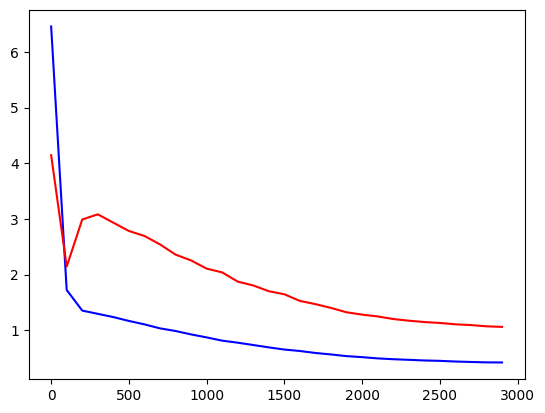

Evaluating 1 hyperparameter combinations...
Training model with hyperparameters:
  Learning rate     : 0.0001
  Iterations        : 3000
  Predictor nodes   : 32
  Dropout           : 0.2
  Combination index : (0, 0, 0, 0, 0, 0)
TN: 7317, FN: 1785, FP: 14674, TP: 18026

 Saved 1 hyperparameter runs to: metrics_basic.csv
Evaluating on test set...
TN: 14545, FN: 3631, FP: 29590, TP: 35840
Test metrics: {'eval_file': None, 'learning_rate': 0.0001, 'num_iters': 3000, 'num_nodes': 32, 'num_nodes_adv': None, 'dropout_rate': 0.2, 'alpha': None, 'accuracy': 0.6026481353012941, 'recall': np.float64(0.9080084112384009), 'precision': np.float64(0.5477609659176911), 'specificity': np.float64(0.3295570408971724), 'f1score': np.float64(0.6833109265650534), 'roc_auc': np.float64(0.618782726067939), 'auc_low': np.float64(0.7301674800695506), 'auc': np.float64(0.7334821875623392), 'auc_high': np.float64(0.7367878629825655), 'equal_opportunity_diff': np.float64(0.08426680977869483), 'equalized_odds_diff

In [ ]:
trainer = Trainer("/content/basic_model_config.json")
trainer.train()

#Pickle data for adversarial training

In [ ]:
correct_json = {
  "Xtrain": "data/X_train.pkl",
  "Xvalid": "data/X_valid.pkl",
  "Xtest": "data/X_test.pkl",
  "ytrain": "data/y_train.pkl",
  "yvalid": "data/y_valid.pkl",
  "ytest": "data/y_test.pkl",
  "ztrain": "data/Z_ethnicity_train.pkl",
  #"zmatch": "data/Z_age_train.pkl",
  "zvalid": "data/Z_ethnicity_valid.pkl",
  "ztest": "data/Z_ethnicity_test.pkl",
  "z_group_map": "data/z_group_map.pkl",
  "method": "adv",
  "num_classes": 10,
  "hyperparameters": {
    "learning_rate": [1e-4],
    "num_iters": [3000],
    "num_nodes": [32],
    "num_nodes_adv": [16],
    "dropout_rate": [0.2],
    "alpha": [5]
  }
}

with open("/content/adv_model_config.json", "w") as f:
    json.dump(correct_json, f, indent=4)

print("UPDATED FILE CONTENT:")
!cat /content/adv_model_config.json


UPDATED FILE CONTENT:
{
    "Xtrain": "data/X_train.pkl",
    "Xvalid": "data/X_valid.pkl",
    "Xtest": "data/X_test.pkl",
    "ytrain": "data/y_train.pkl",
    "yvalid": "data/y_valid.pkl",
    "ytest": "data/y_test.pkl",
    "ztrain": "data/Z_ethnicity_train.pkl",
    "zvalid": "data/Z_ethnicity_valid.pkl",
    "ztest": "data/Z_ethnicity_test.pkl",
    "z_group_map": "data/z_group_map.pkl",
    "method": "adv",
    "num_classes": 10,
    "hyperparameters": {
        "learning_rate": [
            0.0001
        ],
        "num_iters": [
            3000
        ],
        "num_nodes": [
            32
        ],
        "num_nodes_adv": [
            16
        ],
        "dropout_rate": [
            0.2
        ],
        "alpha": [
            5
        ]
    }
}

Loading config from: /content/adv_model_config.json
original xtrain:  torch.Size([292617, 10])
Iteration: 0
Predictor train loss: 4.0098
Predictor valid loss: 3.6052
Adversary train loss: 2.2890
Adversary valid loss: 2.2891
Combined train loss:  -7.4354
Combined valid loss:  -7.8401
Iteration: 100
Predictor train loss: 1.9207
Predictor valid loss: 1.9950
Adversary train loss: 2.2915
Adversary valid loss: 2.2918
Combined train loss:  -9.5368
Combined valid loss:  -9.4638
Iteration: 200
Predictor train loss: 1.5312
Predictor valid loss: 1.6049
Adversary train loss: 2.2952
Adversary valid loss: 2.2953
Combined train loss:  -9.9447
Combined valid loss:  -9.8719
Iteration: 300
Predictor train loss: 1.2229
Predictor valid loss: 1.2949
Adversary train loss: 2.2989
Adversary valid loss: 2.2992
Combined train loss:  -10.2717
Combined valid loss:  -10.2011
Iteration: 400
Predictor train loss: 0.9870
Predictor valid loss: 1.0306
Adversary train loss: 2.3027
Adversary valid loss: 2.3029
Combined t

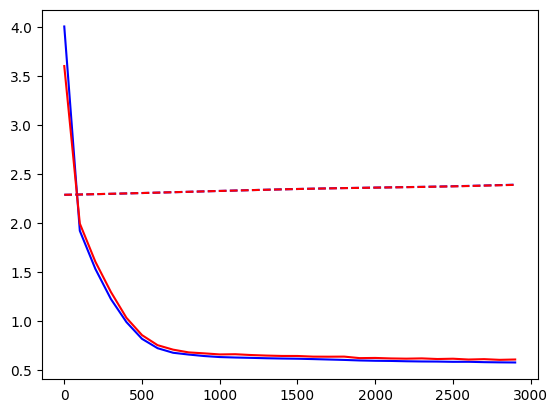

Evaluating 1 hyperparameter combinations...
Training model with hyperparameters:
  Learning rate     : 0.0001
  Iterations        : 3000
  Predictor nodes   : 32
  Dropout           : 0.2
  Combination index : (0, 0, 0, 0, 0, 0)
  Alpha             : 5
  Adversary nodes   : 16
TN: 14758, FN: 4986, FP: 7233, TP: 14825

 Saved 1 hyperparameter runs to: metrics_adv.csv
Evaluating on test set...
TN: 29421, FN: 10093, FP: 14714, TP: 29378
Test metrics: {'eval_file': None, 'learning_rate': 0.0001, 'num_iters': 3000, 'num_nodes': 32, 'num_nodes_adv': 16, 'dropout_rate': 0.2, 'alpha': 5, 'accuracy': 0.7032868454417147, 'recall': np.float64(0.7442932786094236), 'precision': np.float64(0.6662886691461793), 'specificity': np.float64(0.6666137985724104), 'f1score': np.float64(0.7031341572639643), 'roc_auc': np.float64(0.7054535385910868), 'auc_low': np.float64(0.7727023227764949), 'auc': np.float64(0.775720148208145), 'auc_high': np.float64(0.778696214356598), 'equal_opportunity_diff': np.float64(

In [ ]:
trainer = Trainer("/content/adv_model_config.json")
trainer.train()